In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def read_csv(file, columns, timecolumn):
    """funkcija za čitanje podataka vremenske serije.
    Args:
        file(str): putanja do csv datoteke
        columns(list of str): značajke
        timecolumn(str): značajka vremena
    Returns:
         učitani dataframe
    """
    df = pd.read_csv(file,usecols=columns, parse_dates=[timecolumn], encoding='latin1')
    return df

Primjer učitavanja vrijednosti 9-12 mjeseca 2023 u dataframe

In [3]:
combined_df = pd.DataFrame()
for i in range(9,13):
        file = r"bojler_{}_{}-filled.csv".format(i,2023)
        df = read_csv(file, columns=['time','total_active_power'], timecolumn='time')
        df=df.set_index('time')
        #data_hourly = df['total_active_power'].resample('15T').mean()
        #combined_df = pd.concat([combined_df, data_hourly], axis=0)
        combined_df = pd.concat([combined_df, df['total_active_power']], axis=0)
combined_df.rename(columns={combined_df.columns[0]:'total_active_power'},inplace=True)

C:\Users\matea\AppData\Local\Temp\ipykernel_18260\4060170978.py:9: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  combined_df = pd.concat([combined_df, df['total_active_power']], axis=0)


Funkcije za istraživanje stršećih vrijednosti

In [18]:
def plotFeature(df, feature):
    """
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        feature(str): značajka čiju se vrijednost iscrtava
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index,df[feature], marker='o', linestyle='-')
    plt.title(f'Prikaz vrijednosti {feature} u vremenu')
    plt.xlabel('vrijeme')
    plt.ylabel('snaga / W')
    plt.grid(True)
    plt.xticks(rotation=45, ha="right")
    plt.show()

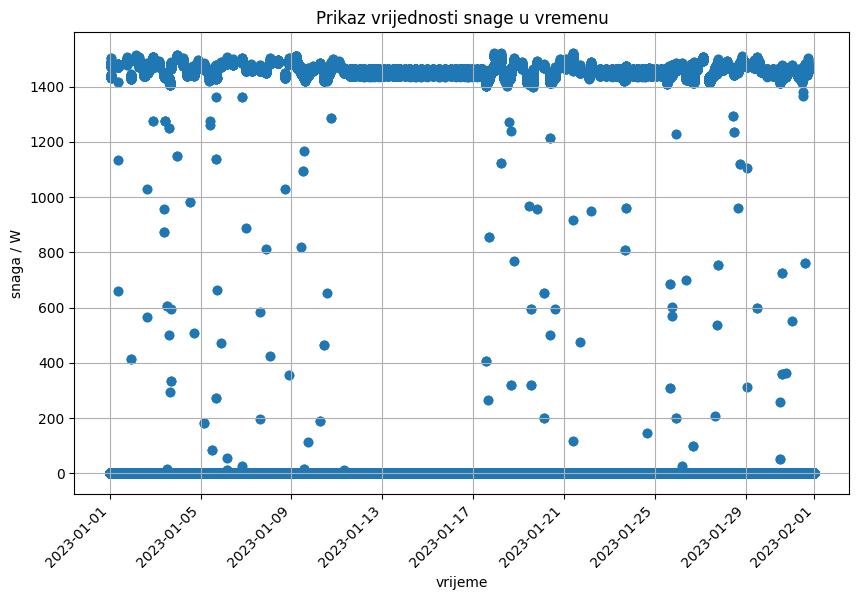

In [23]:
plotFeature(combined_df,'total_active_power')

In [102]:
def averageNonZeroFeature(df, column):
    """
    Računa prosječnu vrijednost značajke kad nije 0.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
    Returns: 
        int prosječnu vrijednost
    """
    return df[df[column]>0][column].mean()

In [104]:
def calcDelta(df, column, plot=False): 
    """
    Dodavanje udaljenosti točaka od prosjeka u df.
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        column (str): značajka
        plot (bool): ako True, iscrtava graf odmaka od srednje vrijednosti
    """
    if(df.empty):
        return
    mean = averagePowerWhenOn(df)
    df.loc[:, 'delta'] = np.where(
        np.abs(mean - df[column]) < np.abs(df[column]),
        -np.abs(mean - df[column]),
        np.abs(0 - df[column])
    )
    if plot:
        plt.figure(figsize=(10, 6))
        plt.scatter(df.index, df['delta'], marker='o', linestyle='-')
        plt.title(f'Odmak {column} od prosječne vrijednosti')
        plt.xlabel('vrijeme')
        plt.ylabel('odmak')
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.show()

In [99]:
def findOutliers(df, feature, treshold):
    """
    Određivanje točaka udaljenih za >treshold*std od prosjeka 
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        feature (str): značajka
        treshold (int): granica outliera, broj standradnih devijacija za koje točka smije biti udaljena od prosjeka da bi ju se smatralo stršećom; manji broj djeluje strože 
    Returns:
        dataframe svih točaka udaljenih za >treshold*std od prosjeka 
    """
    if(df.empty):
        return
    calcDelta(df,feature)
    mean_delta = df['delta'].mean()
    std_delta = df['delta'].std()
    z_scores = (df['delta'] - mean_delta) / std_delta
    outliers = df[abs(z_scores) > treshold]
    outliers = pd.concat([outliers, df[df['total_active_power'] < 0]])
    return outliers

In [100]:
def plotOutliers(df, feature, treshold):
    """
    Izračun i grafički prikaz stršećih vrijednosti
    Args:
        df (Pandas dataframe): dataframe s vremenskim indexom
        feature (str): značajka
        treshold (int): granica outliera, broj standradnih devijacija za koje točka smije biti udaljena od prosjeka da bi ju se smatralo stršećom; manji broj djeluje strože 
    Returns:
        dataframe pravih outliera
    """
    if(df.empty):
        return
    outliers = findOutliers(df, feature, treshold)
    false_outliers = outliers[(outliers['total_active_power']<=averagePowerWhenOn(df)) & (outliers['total_active_power']>0)]
    true_outliers = outliers[(outliers['total_active_power']>averagePowerWhenOn(df)) | (outliers['total_active_power']<0)]
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, y=df['total_active_power'], label='točni podaci')
    plt.scatter(true_outliers.index, y=true_outliers['total_active_power'], color='red', label='pravi outlieri')
    plt.scatter(false_outliers.index, y=false_outliers['total_active_power'], color='yellow', label='lažni outlieri')
    plt.xlabel('trenutak')
    plt.ylabel('snaga')
    plt.title("postotak outliera:{}%".format(round(len(true_outliers)/len(df)*100,2)))
    plt.legend(loc="upper right")
    plt.xticks(ha="right", rotation=45)
    plt.show()
    return true_outliers

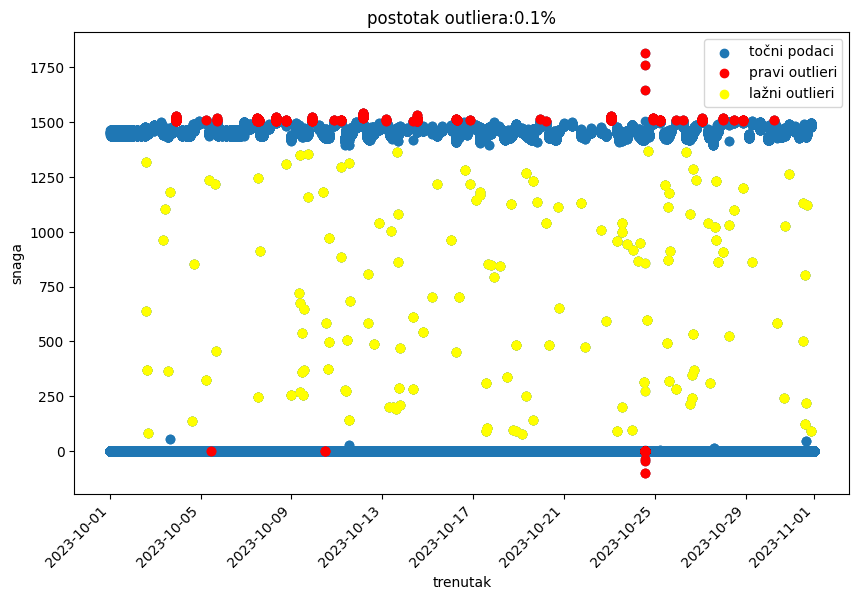

,total_active_power,delta
time,,
2023-10-03 22:22:50,1.528000e+03,-8.054449e+01
2023-10-03 22:22:53,1.528000e+03,-8.054449e+01
2023-10-03 22:22:55,1.528000e+03,-8.054449e+01
2023-10-03 22:22:57,1.523000e+03,-7.554449e+01
2023-10-03 22:22:59,1.523000e+03,-7.554449e+01
...,...,...
2023-10-24 13:40:43,-9.848399e-302,9.848399e-302
2023-10-24 13:40:57,-7.598761e-305,7.598761e-305
2023-10-24 13:41:03,-1.998212e-306,1.998212e-306


In [101]:
plotOutliers(df,'total_active_power',7)

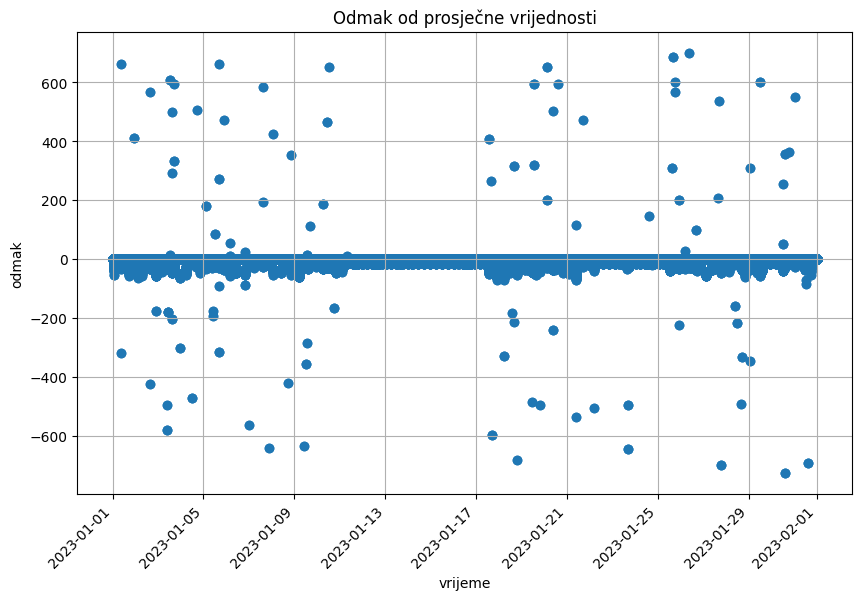

In [103]:
calcDelta(combined_df,'total_active_power', True)